In [540]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix


In [541]:
news=pd.read_csv('Data/train.csv', index_col='id')

print(news.shape)
news.head()

(20800, 4)


,title,author,text,label
id,,,,
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


label counts : [10387 10413]


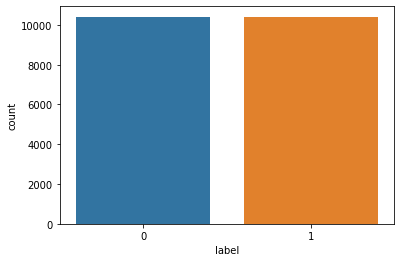

In [542]:
print('label counts :', np.bincount(news.label))

sns.countplot(x=news.label)

### Investigating DataSet

In [543]:
news.dtypes

title     object
author    object
text      object
label      int64
dtype: object

In [544]:
news['len']=news.text.apply(lambda x:len(str(x)))

news.head()

,title,author,text,label,len
id,,,,,
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,4930
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,4160
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,7692
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,3237
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,938


### Checking the news length distribution for each label 

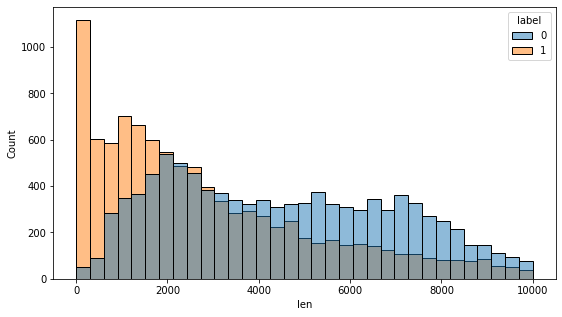

In [545]:
plt.figure(figsize=(9,5))
sns.histplot(x=news.len, hue=news.label,binrange=(0,10000))

#### Observation 1: we have more `Fake News` with a `shorter text length `


# Check Missing Values

In [546]:
news.isnull().sum()

title      558
author    1957
text        39
label        0
len          0
dtype: int64

In [547]:
news[news.label==0].head()

,title,author,text,label,len
id,,,,,
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,4160
5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0,1192
7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0,4923
8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,0,8177
9,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,0,10261


In [548]:
news[news.text.isnull()].tail(10)

,title,author,text,label,len
id,,,,,
13107,Les gardes-frontières se mettent en alerte pou...,NaN,NaN,1,3
13915,Elle met en fuite un braqueur en lui jetant de...,NaN,NaN,1,3
14499,Primaire – François Fillon se désiste au profi...,NaN,NaN,1,3
14933,La sortie du dernier livre inédit du Gorafi éc...,NaN,NaN,1,3
16126,Vendée Globe – Un skipper fait demi-tour après...,NaN,NaN,1,3
18479,Il se fait cryogéniser dans l’espoir de voir u...,NaN,NaN,1,3
18757,Donald Trump en 5 dates >> Le Gorafi,NaN,NaN,1,3
19157,110% des Américains assurent qu’ils continuero...,NaN,NaN,1,3
19227,Des millions d’Américains recherchent massivem...,NaN,NaN,1,3


In [549]:
news.title[18757]

'Donald Trump en 5 dates >> Le Gorafi'

In [550]:
# all records with empty title have label=1 
news[(news.title.isnull())&(news.label==0)].count()

title     0
author    0
text      0
label     0
len       0
dtype: int64

In [551]:
print(news.shape)
ids=news[(news.text.isnull())|(news.text.isnull())].index # only drop rows without title or text
news=news[~news.index.isin(ids)]
news.shape

(20800, 5)


(20761, 5)

### Author is not part of input for our model so we remove author column and and other rows with missing value

In [552]:
# Now let's import Necessary libraries for LSTM
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.preprocessing.text import one_hot
from keras.layers import LSTM,Bidirectional, GRU
from keras.layers import Dense,Dropout, BatchNormalization

In [553]:
vocab_size=10000

TK=Tokenizer(num_words=vocab_size)

X=news.text
y=news.label
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [554]:
TK.fit_on_texts(X_train.values)

In [555]:
TK.index_word

{1: 'the',
 2: 'to',
 3: 'of',
 4: 'and',
 5: 'a',
 6: 'in',
 7: 'that',
 8: 'is',
 9: 'for',
 10: 'on',
 11: '”',
 12: 'was',
 13: 'with',
 14: 'it',
 15: 'as',
 16: 'he',
 17: 'said',
 18: 'by',
 19: 'at',
 20: 'are',
 21: 'have',
 22: 'be',
 23: 'his',
 24: 'not',
 25: 'from',
 26: 'mr',
 27: 'this',
 28: 'has',
 29: 'but',
 30: 'an',
 31: 'they',
 32: 'i',
 33: 'who',
 34: 'you',
 35: '—',
 36: 'had',
 37: 'trump',
 38: 'or',
 39: 'their',
 40: 'about',
 41: 'we',
 42: 'will',
 43: 'one',
 44: 'were',
 45: 'she',
 46: 'more',
 47: 'would',
 48: 'her',
 49: 'been',
 50: 'people',
 51: 'which',
 52: 'all',
 53: 'what',
 54: 'if',
 55: 'when',
 56: 'new',
 57: 'out',
 58: 'its',
 59: 'so',
 60: 'there',
 61: 'up',
 62: 'like',
 63: 'can',
 64: 'no',
 65: 'after',
 66: 'also',
 67: 'than',
 68: 'president',
 69: 'other',
 70: 'our',
 71: 'some',
 72: 'into',
 73: 'clinton',
 74: 'them',
 75: 'over',
 76: 'just',
 77: 'do',
 78: 'time',
 79: 'now',
 80: 'him',
 81: 'us',
 82: 'state',
 

In [556]:
X_train=TK.texts_to_sequences(X_train.values)
X_test=TK.texts_to_sequences(X_test.values)

In [557]:
# using pad_sequence to make each text get equal weight

X_train=pad_sequences(X_train,maxlen=100)
X_test=pad_sequences(X_test,maxlen=100)

In [558]:
X_train[1]

array([  51, 2903,    6,   71,  827,    2,    1, 2128,    3,   71,    6,
          1, 2090,    2,  139,  536,   24,  558,   41,  158,    2,   22,
          5,  187,    3,    7, 2468,  574,    4,   34,   63,  178,  148,
          1,  671,    3,  354,  179,    1, 8678,  109, 4169,    4,  144,
       1337,    3, 7042,    8,  229, 3941,   71,  354,   21,    5,  467,
         78,   85,    6,    1,  306,    3, 4990,   29,    1, 1472, 3343,
         27,  785,  747,    8, 2563,  229, 6737,    1,  771,    3,   71,
        144, 8417,    4, 2335,    3,    5,  450,    1,  106,   47,  324,
       1958,  921,    2,  418,   13,   11,  380, 5280,  866,   10,  195,
       5750], dtype=int32)

In [561]:


## Creating model Using LSTM
embedding_vector_features=40
model=Sequential([
        Embedding(vocab_size,embedding_vector_features,input_length=100),
        Bidirectional(GRU(100)),
        Dropout(0.33),
        Dense(1,activation='sigmoid')
        ])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())


Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 100, 40)           400000    
_________________________________________________________________
bidirectional_24 (Bidirectio (None, 200)               84600     
_________________________________________________________________
dropout_14 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 201       
Total params: 484,801
Trainable params: 484,801
Non-trainable params: 0
_________________________________________________________________
None


In [562]:
model_fit = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64, verbose=1)

/Users/imanjani/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Train on 13909 samples, validate on 6852 samples
Epoch 1/10
13909/13909 [==============================] - 22s 2ms/step - loss: 0.3097 - accuracy: 0.8704 - val_loss: 0.1891 - val_accuracy: 0.9240
Epoch 2/10
13909/13909 [==============================] - 23s 2ms/step - loss: 0.1129 - accuracy: 0.9597 - val_loss: 0.2208 - val_accuracy: 0.9057
Epoch 3/10
13909/13909 [==============================] - 25s 2ms/step - loss: 0.0615 - accuracy: 0.9812 - val_loss: 0.2705 - val_accuracy: 0.9219
Epoch 4/10
13909/13909 [==============================] - 25s 2ms/step - loss: 0.0335 - accuracy: 0.9900 - val_loss: 0.2459 - val_accuracy: 0.9221
Epoch 5/10
13909/13909 [==============================] - 28s 2ms/step - loss: 0.0156 - accuracy: 0.9962 - val_loss: 0.3169 - val_accuracy: 0.9209
Epoch 6/10
13909/13909 [==============================] - 29s 2ms/step - loss: 0.0080 - accuracy: 0.9980 - val_loss: 0.3343 - val_accuracy: 0.9231
Epoch 7/10
13909/13909 [==============================] - 28s 2ms/ste

## Performance Matrics & Accuracy

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9d3e2a9e10>)

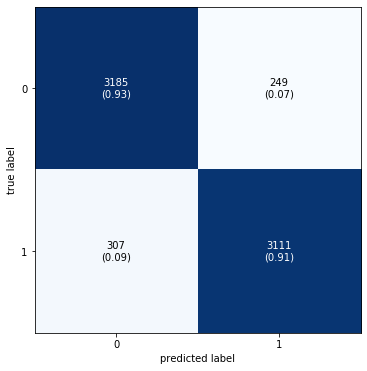

In [563]:
conf = confusion_matrix(y_test,model.predict_classes(X_test))
plot_confusion_matrix(conf,figsize=(6,6),show_normed=True)

In [564]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,model.predict_classes(X_test))


0.9188558085230589

In [565]:
def plot_learning_curve(model_fit,epochs):
    #Accuracy
    epoch_range = range(1,epochs+1)
    plt.plot(epoch_range,model_fit.history['accuracy'])
    plt.plot(epoch_range,model_fit.history["val_accuracy"])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(["Train","Val"],loc ="upper left")
    plt.show()

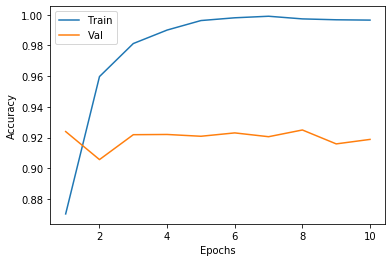

In [566]:
plot_learning_curve(model_fit,10)

# Points 

- GRU is faster than LSTM
- Keras Tokenizer wirh embedding layer works great >90% accuracy